<a href="https://colab.research.google.com/github/Nafew-I/Aircraft-Classification-Using-Sattelite-Imagery/blob/main/Final_Copy_of_Aircraft_Classification_from_Satellite_Imagery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image Processing:

In [ ]:
batch_size = 64

train_dir = '/content/drive/MyDrive/APS360 project/Created Aircraft Dataset' # Path to dataset

# Transform resizes the image, converts it to tensor, and normalizes it
transform = transforms.Compose([
    transforms.Resize((255, 255)),  # Resize to fit the model input size
    transforms.ToTensor(), # Converts to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), # Normalizes tensor
    transforms.GaussianBlur(kernel_size = (3,3), sigma = (3,8)), # Applies gaussian blur to images
    transforms.Grayscale(num_output_channels=1) # Converts images to black and white images
    # Fine-tuning
])

In [ ]:
# Preprocessing
dataset = datasets.ImageFolder(root=train_dir, transform=transform)
train_data, test_data, val_data = random_split(dataset, [0.8, 0.1, 0.1])

# Data loading:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, pin_memory=True)

# Model Definition:

In [ ]:
model = torchvision.models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_classes = 9
model.fc = nn.Linear(model.fc.in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


In [ ]:
# Fully-connected layer for classification
device = next(iter(trainloader))[0].device
model = model.to(device)

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) #can change

# Training:

In [ ]:
# Training loop
def train(model, trainloader, valloader, batch_size=64, num_epochs=10, learn_rate=0.001):
  training_iter, losses, training_accuracy = [], [], []
  iter_num = 0
  for epoch in range(num_epochs):
    model.train()
    for inputs, labels in trainloader:
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          training_iter.append(iter_num)
          losses.append(float(loss))
          training_accuracy.append(accuracy(model, batch_size=batch_size, train=True))
          print("Training Accuracy: ", training_accuracy[-1], "-- Loss: ", losses[-1])
          loss.backward()
          optimizer.step()
          iter_num+=1


  #evaluate on test set
  model.eval()

  return training_accuracy, losses, training_iter

In [ ]:
def accuracy (model, batch_size, train):
  if train:
    dataset = train_data
  else:
    dataset = val_data

  num_correct = 0
  num_total = 0

  for inputs, labels in torch.utils.data.DataLoader(dataset, batch_size=batch_size):
    outputs = model(inputs)

    #update number correct and number total
    prediction = outputs.max(1, keepdim=True)[1]
    num_correct += prediction.eq(labels.view_as(prediction)).sum().item()
    num_total += inputs.shape[0]

  #accuracy calculation
  accuracy = num_correct/num_total
  return accuracy

# Validation:


In [ ]:
def validation (model, data, batch_size=64, num_epochs=10):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  validation_iter, losses, validation_accuracy = [], [], []
  iter_num = 0

  for i in range(num_epochs):
    for inputs, labels in iter(valloader):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      validation_iter.append(iter_num)
      losses.append(float(loss))
      validation_accuracy.append(accuracy(model, batch_size=batch_size, train=False))
      print("Validation Accuracy: ", validation_accuracy[-1], "-- Loss: ", losses[-1] )
      iter_num+=1

  return validation_accuracy, losses, validation_iter

# Plotting (Training and Validation):



In [ ]:
def plotting(training_accuracy, validation_accuracy, training_iter, validation_iter, training_losses, validation_losses):

  #Accuracy vs Number of Iterations

  plt.title("Training Curves")
  plt.plot(training_iter, training_accuracy, label="Training")
  plt.plot(validation_iter, validation_accuracy, label="Validation")
  plt.ylabel("Accuracy")
  plt.xlabel("Iterations")
  plt.legend(loc="best") #Automatically determines optimal location to place legend
  plt.show()

  #Loss vs number of iterations

  plt.title("Loss vs Number of Iterations")
  plt.plot(training_iter, training_losses, label="Training")
  plt.plot(validation_iter, validation_losses, label="Validation")
  plt.ylabel("Loss")
  plt.xlabel("Iterations")
  plt.legend(loc="best") #Automatically determines optimal location to place legend
  plt.show()

# Results (Training and Validation):

Training Accuracy:  0.1226780185758514 -- Loss:  2.4998936653137207
Training Accuracy:  0.4179566563467492 -- Loss:  1.6885457038879395
Training Accuracy:  0.4996130030959752 -- Loss:  1.6729055643081665
Training Accuracy:  0.5704334365325078 -- Loss:  1.6407227516174316
Training Accuracy:  0.653250773993808 -- Loss:  1.1096577644348145
Training Accuracy:  0.6613777089783281 -- Loss:  0.8098343014717102
Training Accuracy:  0.6931114551083591 -- Loss:  0.857235848903656
Training Accuracy:  0.7298761609907121 -- Loss:  1.0613908767700195
Training Accuracy:  0.7294891640866873 -- Loss:  0.9485840797424316
Training Accuracy:  0.7383900928792569 -- Loss:  1.0969088077545166
Training Accuracy:  0.7174922600619195 -- Loss:  0.7414647936820984
Training Accuracy:  0.7240712074303406 -- Loss:  0.7463080883026123
Training Accuracy:  0.7604489164086687 -- Loss:  0.8532924056053162
Training Accuracy:  0.8006965944272446 -- Loss:  0.7732778787612915
Training Accuracy:  0.8080495356037152 -- Loss:  0

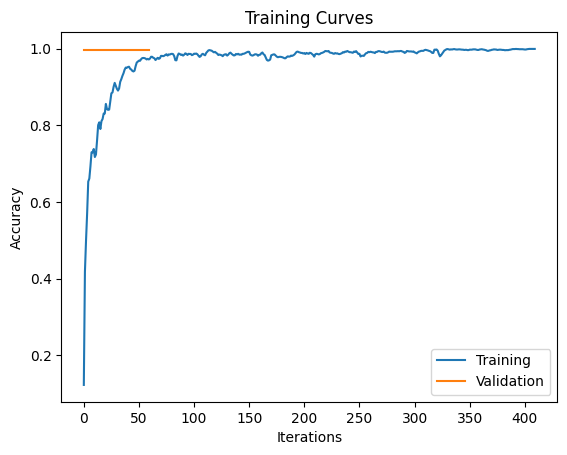

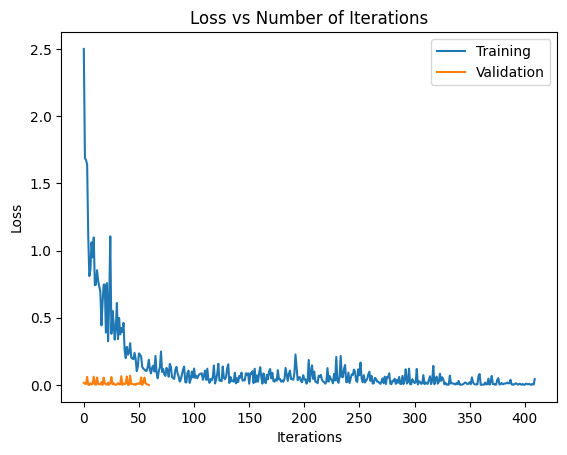

RuntimeError: File /content/drive/MyDrive/Model cannot be opened.

In [ ]:
training_accuracy, training_losses, training_iter = train(model, trainloader, valloader, batch_size=64, num_epochs=10, learn_rate=0.001)
validation_accuracy, validation_losses, validation_iter = validation(model, valloader, batch_size=64, num_epochs=10)
plotting(training_accuracy, validation_accuracy, training_iter, validation_iter, training_losses, validation_losses)

In [ ]:
torch.save(model, "/content/drive/MyDrive/Model.pth")

# Testing:

In [ ]:
#testing code
def testing (model, data, batch_size=64, num_epochs=10):
  testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  test_iter, losses, test_accuracy = [], [], []
  iter_num = 0

  for i in range(num_epochs):
    for inputs, labels in iter(testloader):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      test_iter.append(iter_num)
      losses.append(float(loss))
      test_accuracy.append(accuracy(model, batch_size=batch_size, train=False))
      print("Test Accuracy: ", test_accuracy[-1], "-- Loss: ", losses[-1] )
      iter_num+=1

  return test_accuracy, losses, test_iter

# Results (Testing):

In [ ]:
test_accuracy, test_losses, test_iter = testing(model, testloader, batch_size=64, num_epochs=10)

Test Accuracy:  0.9968944099378882 -- Loss:  0.08126707375049591
Test Accuracy:  0.9968944099378882 -- Loss:  0.012206138111650944
Test Accuracy:  0.9968944099378882 -- Loss:  0.00182531145401299
Test Accuracy:  0.9968944099378882 -- Loss:  0.03597962483763695
Test Accuracy:  0.9968944099378882 -- Loss:  0.0347309336066246
Test Accuracy:  0.9968944099378882 -- Loss:  0.0009074962581507862
Test Accuracy:  0.9968944099378882 -- Loss:  0.019083436578512192
Test Accuracy:  0.9968944099378882 -- Loss:  0.030540917068719864
Test Accuracy:  0.9968944099378882 -- Loss:  0.02905934676527977
Test Accuracy:  0.9968944099378882 -- Loss:  0.003951767925173044
Test Accuracy:  0.9968944099378882 -- Loss:  0.056288376450538635
Test Accuracy:  0.9968944099378882 -- Loss:  0.5806518197059631
Test Accuracy:  0.9968944099378882 -- Loss:  0.003772962372750044
Test Accuracy:  0.9968944099378882 -- Loss:  0.037639327347278595
Test Accuracy:  0.9968944099378882 -- Loss:  0.04511253163218498
Test Accuracy:  0.

# Plotting (Testing):


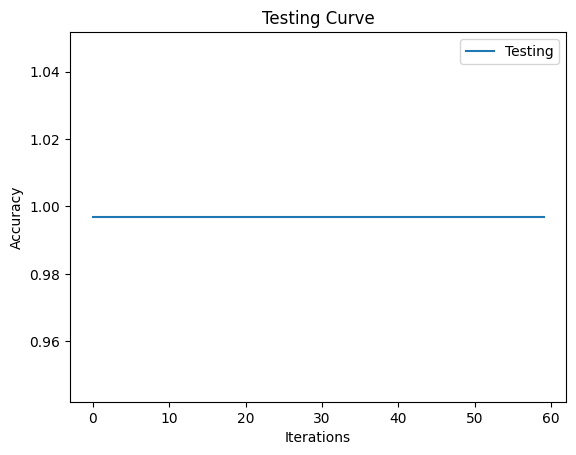

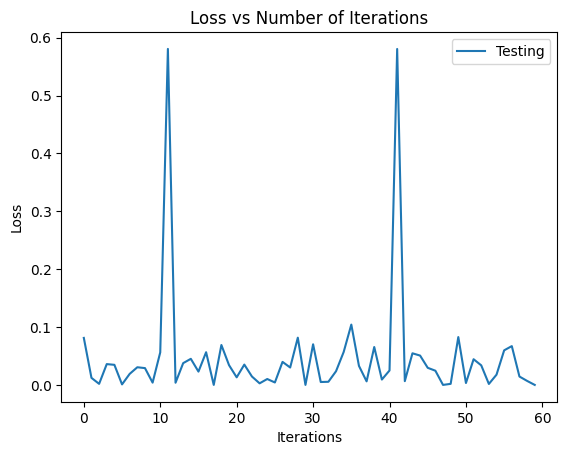

In [ ]:
def plot_test(test_accuracy, test_iter, test_losses):

  #Accuracy vs Number of Iterations

  plt.title("Testing Curve")
  plt.plot(test_iter, test_accuracy, label="Testing")
  plt.ylabel("Accuracy")
  plt.xlabel("Iterations")
  plt.legend(loc="best") #Automatically determines optimal location to place legend
  plt.show()

  #Loss vs number of iterations

  plt.title("Loss vs Number of Iterations")
  plt.plot(test_iter, test_losses, label="Testing")
  plt.ylabel("Loss")
  plt.xlabel("Iterations")
  plt.legend(loc="best") #Automatically determines optimal location to place legend
  plt.show()



plot_test(test_accuracy, test_iter, test_losses)

# Demonstration:

In [ ]:
#demo code
demo_dir = '/content/drive/MyDrive/APS360 project/Testing Demo data (robert use this)'

#preprocessing
demo_data = datasets.ImageFolder(root=demo_dir, transform=transform)

#data loading:
demoloader = torch.utils.data.DataLoader(demo_data, batch_size=batch_size, shuffle=False, pin_memory=True)

classes = demo_data.classes

def demo_display (model, data, batch_size=9):

  for inputs, labels in iter(demoloader):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)

    for i in range(batch_size):

        pred_idx = outputs[i].argmax().item()
        ground_truth_idx = labels[i].item()

        print("Predicted Aircraft:", classes[pred_idx])
        print("Ground Truth Aircraft:", classes[ground_truth_idx])

        input_img = demo_data[i][0].cpu().numpy().transpose((1, 2, 0))
        plt.imshow(input_img)
        plt.show()


Predicted Aircraft: B-1
Ground Truth Aircraft: B-1


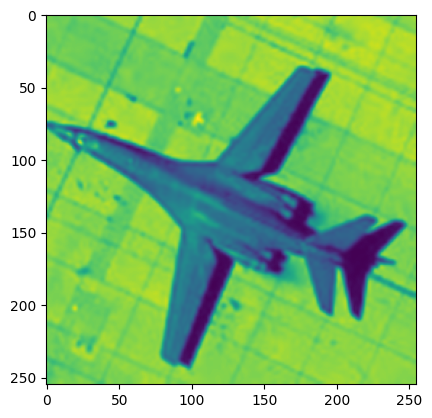

Predicted Aircraft: B-2
Ground Truth Aircraft: B-2


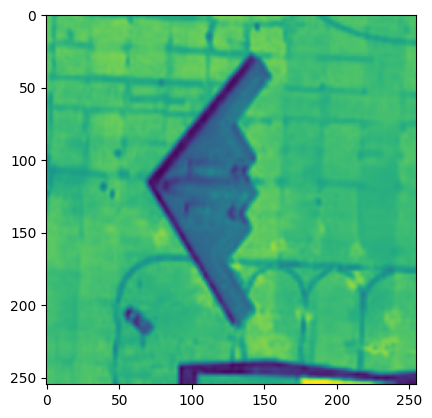

Predicted Aircraft: B-52
Ground Truth Aircraft: B-52


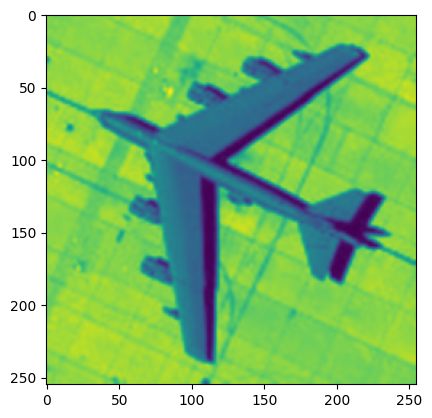

Predicted Aircraft: C-130
Ground Truth Aircraft: C-130


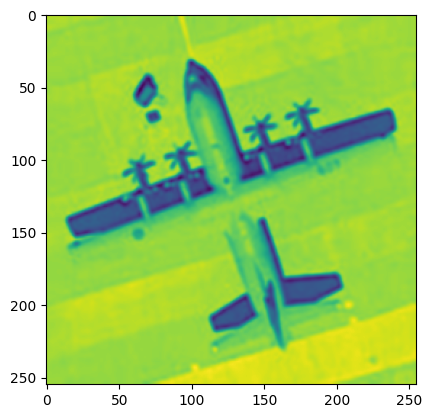

Predicted Aircraft: C-135
Ground Truth Aircraft: C-135


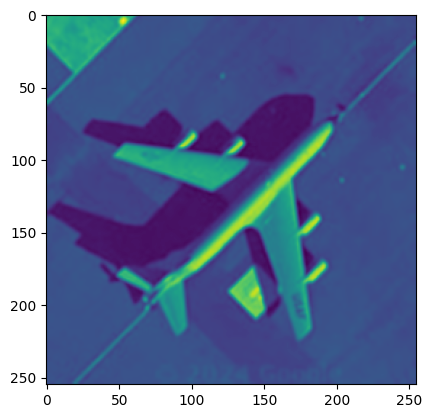

Predicted Aircraft: C-17
Ground Truth Aircraft: C-17


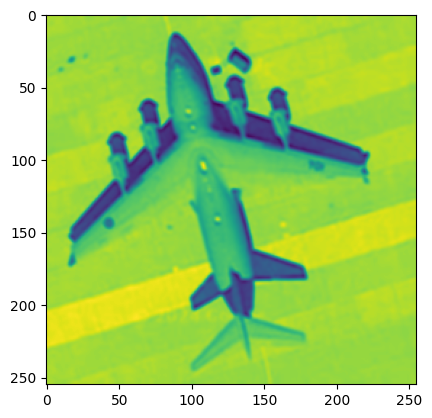

Predicted Aircraft: C-5
Ground Truth Aircraft: C-5


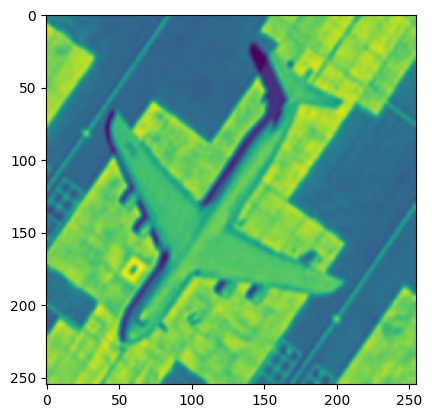

Predicted Aircraft: E-3
Ground Truth Aircraft: E-3


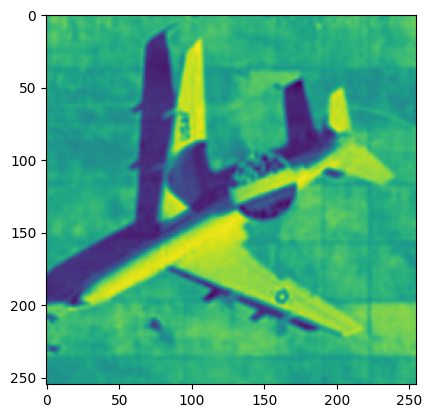

Predicted Aircraft: KC-10
Ground Truth Aircraft: KC-10


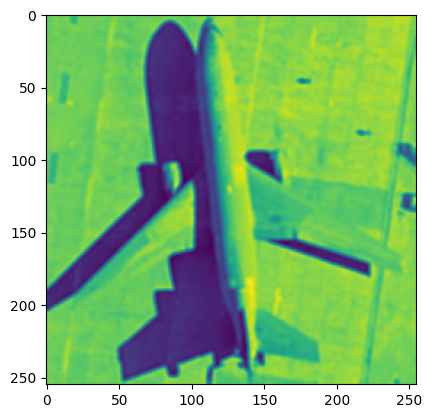

In [ ]:
model = torch.load("/content/drive/MyDrive/APS360 project/Final Primary Model/Model.pth") # Load Model
demo_display(model, demoloader, batch_size=9) # Demo